In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage
import bombcell as bc

✅ ipywidgets available - interactive GUI ready


In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib ipympl

### Functions

In [6]:
## Developed in NPX_find_bursts_testing.ipynb, this version is faster and only returns start times and spike counts ##
## For LTS bursts, often associated with thalamocortical units ##
def find_LTS_bursts(spike_times):
    ## Set ISI parameters ##
    pre_ISI = 0.1
    first_ISI = 0.005
    other_ISI = 0.01
    
    preISIs = np.diff(spike_times)[:-1]
    postISIs = np.diff(spike_times)[1:]
    ## Find starts ##
    bs_inds = np.nonzero((preISIs > pre_ISI) * (postISIs < first_ISI))[0]
    if len(bs_inds) == 0:
        return np.array([]), np.array([])
    
    burst_starts = bs_inds + 1 # +1 corrects for the actual spike ind
    ## Loop through burst starts to find spikes that belong to the burst
    burst_counts = []
    for st_ind in bs_inds:
        spkind = st_ind+1
        bcount = 1
        while (spkind < len(preISIs)) and (preISIs[spkind] < other_ISI):
            spkind += 1
            bcount += 1
        burst_counts.append(bcount)
    
    return spike_times[burst_starts], np.array(burst_counts)

# Load experiment

In [7]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})
all_subexp.head()

,genotype,mouse,experiment,drug,inj_time,sweep_states,bad_chs,CCFres,NPX_analysis,EEG_analysis,skull_screws,NPX_ref,EEG_ref,shared_ref_gnd,data_loc,notes
0,GAT1-KO,645606,EEGNPXspont_estim_2022-12-20_12-26-39,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_esti...,100um offset stim electrode
1,GAT1-KO,644565,EEGNPXspont_estim_2022-12-22_10-36-08,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_esti...,"100um offset stim electrode, probeB LFP estim ..."
2,GAT1-KO,672785,EEGNPXspont_estim_2023-07-05_12-39-59,none,0,awake,all,25,True,False,2.0,Neuropixels tip reference electrode,"stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672785\EEGNPXspont_esti...,EEG has low amplitude signals and all chs look...
3,GAT1-KO,672789,EEGNPXspont_estim_2023-07-13_13-28-01,none,0,awake,none,25,True,True,2.0,"stainless steel skull screw, right CB","stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_esti...,NaN
4,wildtype,654181,estim_vis_2022-11-22_09-42-58,isoflurane,0,"awake,isoflurane","7,8,11,13",25,True,True,NaN,NaN,NaN,NaN,F:\psi_exp\mouse654181\estim_vis_2022-11-22_09...,good control mouse with RT units


In [8]:
all_subexp[10:15]

,genotype,mouse,experiment,drug,inj_time,sweep_states,bad_chs,CCFres,NPX_analysis,EEG_analysis,skull_screws,NPX_ref,EEG_ref,shared_ref_gnd,data_loc,notes
10,wildtype,655956,estim_2022-12-15_10-07-59,saline,2165,"awake,saline",none,25,True,True,NaN,Neuropixels tip reference electrode,"stainless steel skull screw, left CB","separate ref, shorted gnd",F:\psi_exp\mouse655956\estim_2022-12-15_10-07-...,"Good EEG, and RT units"
11,wildtype,689239,aw_iso_2023-08-09_11-15-42,isoflurane,0,"awake,isoflurane","13,28",25,True,True,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, mid CB","separate ref, shared gnd",F:\psi_exp\mouse689239\aw_iso_2023-08-09_11-15...,"Good EEG, and RT units, EP from high amp"
12,wildtype,703063,aw_psi_2023-11-15_11-08-12,psilocybin,3077,"awake,psilocybin","0,3,13",25,True,False,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, mid CB","separate ref, shared gnd",F:\psi_exp\mouse703063\aw_psi_2023-11-15_11-08...,"Many RT units, EP not good"
13,wildtype,703064,aw_iso_2023-11-29_11-23-30,isoflurane,0,"awake,isoflurane","3,9,15,16,21",25,True,False,NaN,"stainless steel skull screw, mid CB","stainless steel skull screw, left CB","separate ref, shared gnd",F:\psi_exp\mouse703064\aw_iso_2023-11-29_11-23...,"Many RT units, EP not good"
14,wildtype,709401,aw_iso_2023-12-13_09-55-07,isoflurane,0,"awake,isoflurane",3,25,True,True,NaN,"stainless steel skull screw, left CB","stainless steel skull screw, mid CB","separate ref, shared gnd",F:\psi_exp\mouse709401\aw_iso_2023-12-13_09-55...,"Some RT, EP good at high amp"


# Test on one session

In [9]:
choose_sub = 1
exprow = all_subexp.iloc[choose_sub]
print(exprow.mouse)
exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)

644565
Experiment type: electrical stimulation


In [10]:
if exprow.NPX_analysis:
    print('Yes, this experiment has good NPX data.')
else:
    print('This experiment does NOT have good NPX data, skip it.')

Yes, this experiment has good NPX data.


In [11]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


### Load experiment data
<br>Load stim log

In [12]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

Load SWD events

In [13]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is.')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Session has no SWD file.')
    autoSWD_df = None

Whoope there it is.


Load EEG timestamps for global time and iso signal to avoid anesthetized period

In [14]:
eegts = np.load(exp.ephys_params['EEG']['timestamps'])

In [15]:
iso_level, isots = exp.load_analog_iso()

## Load unit data

In [16]:
evoked_folder = os.path.join(exp.data_folder, 'evoked_data')
fn_units_info = os.path.join(evoked_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(evoked_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

# unit_info.head()

In [17]:
unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region
0,B0,probeB,0,3680,0.370854,PO,269,162,173,5.108656,0.99,0.788976,0.500000,22225,TH
1,B1,probeB,0,3680,0.398325,PO,269,162,173,11.458331,0.99,0.160769,0.001680,49849,TH
2,B2,probeB,0,3680,0.453266,PO,269,162,173,1.618910,0.99,1.446394,0.500000,7043,TH
3,B3,probeB,1,3680,0.384590,PO,269,162,173,4.637902,0.99,0.100133,0.000948,20177,TH
4,B4,probeB,1,3680,0.494472,PO,269,162,173,6.090622,0.99,0.048773,0.085176,26497,TH


#### First, get the CV in/out of SWD

In [18]:
deltat = 1. # window size, s
atime = eegts[0]
if exprow.genotype == 'GAT1-KO':
    print('GAT1: choose time before any stimuli')
    btime = stim_log.onset.values[0]
    print(' Spontaneous time: {:.2f} s'.format(btime-atime))
else:
    print('Control: some experiments are saline/psilocybin/isoflurane')
    if exprow.drug == 'isoflurane':
        print(' First stim: {:.2f} s; Iso on: {:.2f} s'.format(stim_log.onset.values[0], isots[iso_level > 4][0]))
        btime = np.min([stim_log.onset.values[0], isots[iso_level > 4][0]])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
    else:
        print(' First stim: {:.2f} s; First injection: {:.2f}'.format(stim_log.onset.values[0], exprow.inj_time))
        btime = np.min([stim_log.onset.values[0], exprow.inj_time])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
spontbins = np.arange(atime, btime, deltat)
if exprow.genotype == 'GAT1-KO':
    spontSWD = autoSWD_df[(autoSWD_df['onset'] > atime) & (autoSWD_df['offset'] < btime)]

GAT1: choose time before any stimuli
 Spontaneous time: 2932.62 s


In [19]:
ISI_CV = []
prop2 = []
num_LTS_bursts = []
CV2 = []
ISI_CV_in = []
ISI_CV_out = []
num_bursts_in = []
num_bursts_out = []
for unitind, unitrow in unit_info.iterrows():
    uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
    uISI = np.diff(uspikes)
    ISI_CV.append(np.std(uISI) / np.mean(uISI))
    prop2.append(np.sum(uISI > 2) / len(uISI))
    ubursts, uburstcounts = find_LTS_bursts(uspikes)
    num_LTS_bursts.append(len(ubursts))
    cv_i = np.diff(uISI) / (uISI[:-1] + uISI[1:])
    CV2.append(2. * np.mean(np.abs(cv_i)))

    if exprow.genotype == 'GAT1-KO':
        in_ISI = []
        out_ISI = []
        in_burst = []
        out_burst = []
        for j in range(len(spontSWD)-1):
            SWDeventj = spontSWD.iloc[j]
            SWDeventjj = spontSWD.iloc[j+1]
        
            ## within SWD ##
            SWDspikes = uspikes[np.nonzero((uspikes >= SWDeventj.onset) & (uspikes <= SWDeventj.offset))[0]]
            if len(SWDspikes) > 1:
                in_ISI.append(np.diff(SWDspikes))
            burstinds = np.nonzero((ubursts >= SWDeventj.onset) & (ubursts <= SWDeventj.offset))[0]
            in_burst.append(ubursts[burstinds])
        
            ## out of SWD ##
            nonSWDspikes = uspikes[np.nonzero((uspikes >= SWDeventj.offset) & (uspikes <= SWDeventjj.onset))[0]]
            if len(nonSWDspikes) > 1:
                out_ISI.append(np.diff(nonSWDspikes))
            nonburstinds = np.nonzero((ubursts >= SWDeventj.offset) & (ubursts <= SWDeventjj.onset))[0]
            out_burst.append(ubursts[nonburstinds])
    
        if len(in_ISI) > 1:
            ISI_CV_in.append(np.std(np.concatenate(in_ISI)) / np.mean(np.concatenate(in_ISI)))
        else:
            ISI_CV_in.append(np.nan)
        if len(out_ISI) > 1:
            ISI_CV_out.append(np.std(np.concatenate(out_ISI)) / np.mean(np.concatenate(out_ISI)))
        else:
            ISI_CV_out.append(np.nan)
        num_bursts_in.append(len(np.concatenate(in_burst)))
        num_bursts_out.append(len(np.concatenate(out_burst)))


unit_info['CV_ISI'] = ISI_CV
unit_info['prop2'] = prop2
unit_info['num_LTS_bursts'] = num_LTS_bursts
unit_info['CV2'] = CV2
if exprow.genotype == 'GAT1-KO':
    unit_info['CV_ISI_in'] = ISI_CV_in
    unit_info['num_bursts_in'] = num_bursts_in
    unit_info['CV_ISI_out'] = ISI_CV_out
    unit_info['num_bursts_out'] = num_bursts_out
else:
    unit_info['CV_ISI_out'] = ISI_CV

#### Now get the bombcell classification criteria

In [20]:
bc_wfdur = np.zeros((len(unit_info))) * np.nan
bc_postspike_supp_ms = np.zeros((len(unit_info))) * np.nan
bc_prop_long_isi = np.zeros((len(unit_info))) * np.nan

In [32]:
start = time.time()
probe_list = np.unique(unit_info['probe'].values)
for probei in probe_list:
    probe_unit_info = unit_info[unit_info['probe'] == probei]
    probe_path = os.path.dirname(exp.ephys_params[probei]['spike_clusters'])
    ephys_param = bc.get_ephys_parameters(ephys_path=probe_path)
    whitened_templates = np.load(os.path.join(probe_path, 'templates.npy'))
    winv = np.load(os.path.join(probe_path, 'whitening_mat_inv.npy'))
    for uind, unitrow in probe_unit_info.iterrows():
        uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
        acg_props = bc.compute_acg_properties(uspikes, ephys_param)
        bc_postspike_supp_ms[uind] = acg_props.get('post_spike_suppression_ms', np.nan)
        isi_props = bc.compute_isi_properties(uspikes, ephys_param)
        bc_prop_long_isi[uind] = isi_props.get('prop_long_isi', np.nan)
        utemplates_uw = whitened_templates[int(unitrow.unit_id[1:]),:,:].squeeze() @ winv
        wf_props = bc.compute_waveform_properties(utemplates_uw, ephys_param, float(exp.ephys_params[probei]['ap_sample_rate']))
        bc_wfdur[uind] = wf_props.get('waveform_duration_us', np.nan)
unit_info['bc_wfdur'] = bc_wfdur
unit_info['bc_ps_supp_ms'] = bc_postspike_supp_ms
unit_info['bc_proplongisi'] = bc_prop_long_isi
end = time.time()
print('Time: {:.2f} s'.format(end-start))

TypeError: compute_acg_properties() missing 1 required positional argument: 'param'

In [22]:
unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,CV_ISI,prop2,num_LTS_bursts,CV2,CV_ISI_in,num_bursts_in,CV_ISI_out,num_bursts_out,bc_wfdur,bc_ps_supp_ms,bc_proplongisi
0,B0,probeB,0,3680,0.370854,PO,269,162,173,5.108656,0.99,0.788976,0.500000,22225,TH,2.425659,0.014264,590,1.034553,1.398043,138,2.087172,264,400.0,1.0,0.014264
1,B1,probeB,0,3680,0.398325,PO,269,162,173,11.458331,0.99,0.160769,0.001680,49849,TH,2.072512,0.000883,3054,0.898940,1.576292,843,1.884850,1063,400.0,1.0,0.000883
2,B2,probeB,0,3680,0.453266,PO,269,162,173,1.618910,0.99,1.446394,0.500000,7043,TH,2.638771,0.072991,339,1.163091,1.528207,76,1.859698,141,500.0,1.0,0.072991
3,B3,probeB,1,3680,0.384590,PO,269,162,173,4.637902,0.99,0.100133,0.000948,20177,TH,2.675274,0.018834,1559,0.980496,2.292351,471,2.225969,653,400.0,1.0,0.018834
4,B4,probeB,1,3680,0.494472,PO,269,162,173,6.090622,0.99,0.048773,0.085176,26497,TH,1.560503,0.002114,2884,1.045671,1.376947,971,1.531211,1103,500.0,1.0,0.002114


## Classify cell types
<br> **STR classification** (a la Masmanidis lab, J Neurophysiol 2016): FS [spike_duration < 0.475], TAN [spike_duration > 0.55 & CV < 1.5], MSN [spike_duration > 0.55 & CV > 1.5]
<br> **STR classification** (a la bombcell, https://github.com/Julie-Fabre/bombcell/blob/main/py_bombcell/bombcell/classification.py): need spike duration, propLongISI, and postSpikeSuppression_ms properties to distinguish MSN, FS, TAN, and UIN (unidentified interneuron)
<br> **isocortex classification**: FS [spike_duration < 0.4], RS [spike_duration > 0.4]
<br> thalamus: need to figure out...

In [23]:
## bombcell classification parameters ##
templateDuration_CP_threshold = 400  # microseconds
postSpikeSup_CP_threshold = 40       # milliseconds  
propISI_CP_threshold = 0.1
templateDuration_Ctx_threshold = 400  # microseconds
templateDuration_TH_threshold = 325  # microseconds

In [24]:
## New bombcell classification ##
put_cell_type = []
for unitind, unitrow in unit_info.iterrows():
    if unitrow.parent_region == 'STR':
        if (np.isnan(unitrow.bc_wfdur) or # If any required property is missing, assign Unknown
            np.isnan(unitrow.bc_ps_supp_ms) or 
            np.isnan(unitrow.bc_proplongisi)):
            put_cell_type.append('unknown')
            continue
        if (unitrow.bc_wfdur > templateDuration_CP_threshold and # MSN: wide waveform AND short post-spike suppression
            unitrow.bc_ps_supp_ms < postSpikeSup_CP_threshold):
            put_cell_type.append('MSN')
        elif (unitrow.bc_wfdur <= templateDuration_CP_threshold and # FSI: narrow waveform AND low proportion of long ISIs
              unitrow.bc_proplongisi <= propISI_CP_threshold):
            put_cell_type.append('FSI')
        elif (unitrow.bc_wfdur > templateDuration_CP_threshold and # TAN: wide waveform AND long post-spike suppression
              unitrow.bc_ps_supp_ms >= postSpikeSup_CP_threshold):
            put_cell_type.append('TAN')
        elif (unitrow.bc_wfdur <= templateDuration_CP_threshold and # UIN: narrow waveform AND high proportion of long ISIs
              unitrow.bc_proplongisi > propISI_CP_threshold):
            put_cell_type.append('UIN')
        else: # Should not reach here with valid data
            put_cell_type.append('unknown')
    elif unitrow.parent_region in ['MO', 'SS', 'VIS', 'PL', 'ACA', 'ILA', 'ORB', 'RSP', 'HIP']:
        if unitrow.bc_wfdur > templateDuration_Ctx_threshold:
            put_cell_type.append('RS')
        else:
            put_cell_type.append('FS')
    elif unitrow.parent_region == 'TH':
        if unitrow.bc_wfdur < templateDuration_TH_threshold:
            put_cell_type.append('pRT')
        else:
            put_cell_type.append('TC')
    else:
        put_cell_type.append('unknown')
unit_info['cell_type_bc'] = put_cell_type

In [25]:
## New bombcell classification w/ regular waveform duration ##
put_cell_type = []
for unitind, unitrow in unit_info.iterrows():
    if unitrow.parent_region == 'STR':
        if (np.isnan(unitrow.spike_duration) or # If any required property is missing, assign Unknown
            np.isnan(unitrow.bc_ps_supp_ms) or 
            np.isnan(unitrow.bc_proplongisi)):
            put_cell_type.append('unknown')
            continue
        if (unitrow.spike_duration * 1E3 > templateDuration_CP_threshold and # MSN: wide waveform AND short post-spike suppression
            unitrow.bc_ps_supp_ms < postSpikeSup_CP_threshold):
            put_cell_type.append('MSN')
        elif (unitrow.spike_duration * 1E3 <= templateDuration_CP_threshold and # FSI: narrow waveform AND low proportion of long ISIs
              unitrow.bc_proplongisi <= propISI_CP_threshold):
            put_cell_type.append('FSI')
        elif (unitrow.spike_duration * 1E3 > templateDuration_CP_threshold and # TAN: wide waveform AND long post-spike suppression
              unitrow.bc_ps_supp_ms >= postSpikeSup_CP_threshold):
            put_cell_type.append('TAN')
        elif (unitrow.spike_duration * 1E3 <= templateDuration_CP_threshold and # UIN: narrow waveform AND high proportion of long ISIs
              unitrow.bc_proplongisi > propISI_CP_threshold):
            put_cell_type.append('UIN')
        else: # Should not reach here with valid data
            put_cell_type.append('unknown')
    elif unitrow.parent_region in ['MO', 'SS', 'VIS', 'PL', 'ACA', 'ILA', 'ORB', 'RSP', 'HIP']:
        if unitrow.spike_duration * 1E3 > templateDuration_Ctx_threshold:
            put_cell_type.append('RS')
        else:
            put_cell_type.append('FS')
    elif unitrow.parent_region == 'TH':
        if unitrow.spike_duration * 1E3 < templateDuration_TH_threshold:
            put_cell_type.append('pRT')
        else:
            put_cell_type.append('TC')
    else:
        put_cell_type.append('unknown')
unit_info['cell_type_LC'] = put_cell_type

In [26]:
unit_info.head(10)

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,CV_ISI,prop2,num_LTS_bursts,CV2,CV_ISI_in,num_bursts_in,CV_ISI_out,num_bursts_out,bc_wfdur,bc_ps_supp_ms,bc_proplongisi,cell_type_bc,cell_type_LC
0,B0,probeB,0,3680,0.370854,PO,269,162,173,5.108656,0.99,0.788976,0.500000,22225,TH,2.425659,0.014264,590,1.034553,1.398043,138,2.087172,264,400.000000,1.0,0.014264,TC,TC
1,B1,probeB,0,3680,0.398325,PO,269,162,173,11.458331,0.99,0.160769,0.001680,49849,TH,2.072512,0.000883,3054,0.898940,1.576292,843,1.884850,1063,400.000000,1.0,0.000883,TC,TC
2,B2,probeB,0,3680,0.453266,PO,269,162,173,1.618910,0.99,1.446394,0.500000,7043,TH,2.638771,0.072991,339,1.163091,1.528207,76,1.859698,141,500.000000,1.0,0.072991,TC,TC
3,B3,probeB,1,3680,0.384590,PO,269,162,173,4.637902,0.99,0.100133,0.000948,20177,TH,2.675274,0.018834,1559,0.980496,2.292351,471,2.225969,653,400.000000,1.0,0.018834,TC,TC
4,B4,probeB,1,3680,0.494472,PO,269,162,173,6.090622,0.99,0.048773,0.085176,26497,TH,1.560503,0.002114,2884,1.045671,1.376947,971,1.531211,1103,500.000000,1.0,0.002114,TC,TC
5,B5,probeB,1,3680,0.343384,PO,269,162,173,4.348966,0.99,0.195873,0.079074,18920,TH,2.304097,0.018341,1169,0.997812,1.728330,390,1.990033,474,400.000000,1.0,0.018341,TC,TC
6,B6,probeB,5,3640,0.357119,PO,269,160,173,4.956259,0.99,0.056117,0.001053,21562,TH,2.609929,0.015352,1765,0.924425,2.095463,597,2.079122,685,366.666667,1.0,0.015352,TC,TC
7,B7,probeB,1,3680,0.412060,PO,269,162,173,1.392956,0.99,1.287662,0.451247,6060,TH,2.983437,0.068823,243,1.129227,1.312132,11,1.822043,54,466.666667,1.0,0.068823,TC,TC
8,B8,probeB,2,3660,0.384590,PO,269,161,173,7.798258,0.99,0.461851,0.001503,33926,TH,2.581827,0.005306,2625,0.959916,1.815505,833,2.150234,980,400.000000,1.0,0.005306,TC,TC
9,B9,probeB,2,3660,0.467002,PO,269,161,173,2.650295,0.99,0.171719,0.481475,11530,TH,2.257924,0.044843,348,1.072486,1.556459,124,1.849811,161,466.666667,1.0,0.044843,TC,TC


## Choose a parent region to investigate classification

### STR

In [27]:
pregion = 'STR'
FR_min = 0.05
regi_unitdf = unit_info[(unit_info['parent_region'] == pregion) & (unit_info['firing_rate'] > FR_min)]
print(len(regi_unitdf))
print(np.unique(regi_unitdf['region'].values))
print(np.unique(regi_unitdf['probe'].values))
regi_unitdf.head(10)

534
['CP' 'LSv' 'VL' 'ccg']
['probeF']


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,CV_ISI,prop2,num_LTS_bursts,CV2,CV_ISI_in,num_bursts_in,CV_ISI_out,num_bursts_out,bc_wfdur,bc_ps_supp_ms,bc_proplongisi,cell_type_bc,cell_type_LC
724,F20,probeF,14,3520,0.563149,LSv,198,193,195,0.914157,0.99,0.721665,0.093206,3977,STR,1.123152,0.160966,30,1.028115,0.987107,5,1.160075,19,600.000000,1.0,0.160966,MSN,MSN
725,F22,probeF,17,3500,0.563149,LSv,198,192,195,8.537493,0.99,0.023640,0.108883,37142,STR,1.191723,0.000081,57,0.884505,1.032124,18,1.083783,28,566.666667,55.0,0.000081,TAN,TAN
726,F23,probeF,17,3500,0.494472,LSv,198,192,195,8.169486,0.99,0.121344,0.295591,35541,STR,1.257512,0.000535,200,0.976528,1.124745,51,1.195859,79,500.000000,6.0,0.000535,MSN,MSN
727,F24,probeF,18,3480,0.563149,LSv,198,192,195,2.815796,0.99,0.021732,0.025311,12250,STR,0.938953,0.003184,9,0.915911,0.894587,1,0.903967,2,733.333333,37.0,0.003184,MSN,MSN
728,F26,probeF,19,3480,0.590620,LSv,198,191,195,0.661770,0.99,0.000000,0.023384,2879,STR,1.735865,0.212300,0,1.112921,1.166704,0,2.126773,0,600.000000,6.0,0.212300,MSN,MSN
729,F27,probeF,20,3460,0.412060,LSv,198,191,194,1.600062,0.99,0.100955,0.081672,6961,STR,1.557400,0.073563,12,1.068644,1.169478,2,1.672944,6,433.333333,9.0,0.073563,MSN,MSN
730,F29,probeF,22,3440,0.727973,LSv,197,190,194,0.576031,0.99,0.778948,0.292430,2506,STR,1.285663,0.279042,22,1.044105,0.974562,4,1.411877,12,666.666667,1.0,0.279042,MSN,MSN
731,F30,probeF,23,3440,0.563149,LSv,197,190,194,1.786019,0.99,0.054018,0.008523,7770,STR,1.194874,0.037843,25,1.065653,0.980689,5,1.217836,10,533.333333,4.0,0.037843,MSN,MSN
732,F31,probeF,23,3440,0.645561,LSv,197,190,194,2.172415,0.99,0.018255,0.016012,9451,STR,1.118162,0.021376,6,0.910483,0.872638,3,1.011698,2,633.333333,26.0,0.021376,MSN,MSN
733,F32,probeF,23,3440,0.453266,LSv,197,190,194,10.056874,0.99,0.001704,0.000120,43752,STR,1.215235,0.000069,23,0.852740,1.076444,7,1.088892,11,466.666667,37.0,0.000069,MSN,MSN


STR classification (a la Masmanidis lab, J Neurophysiol 2016)

Text(0.5, 1.0, 'STR putative cell types (bombcell)')

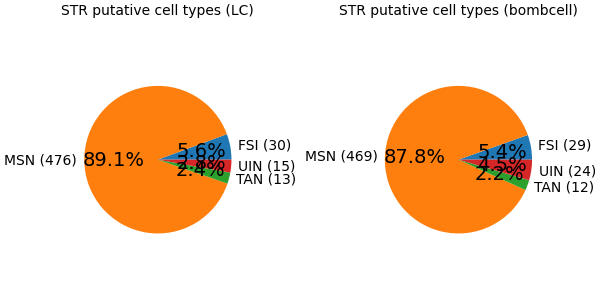

In [28]:
labels = []
count = []
for typei in np.unique(regi_unitdf['cell_type_LC'].values):
    tdf = regi_unitdf[regi_unitdf['cell_type_LC'] == typei]
    labels.append('{} ({:d})'.format(typei, len(tdf)))
    count.append(len(tdf))

labelsbc = []
countbc = []
for typei in np.unique(regi_unitdf['cell_type_bc'].values):
    tdf = regi_unitdf[regi_unitdf['cell_type_bc'] == typei]
    labelsbc.append('{} ({:d})'.format(typei, len(tdf)))
    countbc.append(len(tdf))


fig, axs = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
axs[0].pie(count, labels=labels, autopct='%1.1f%%')
axs[0].axis('equal')
axs[0].set_title('{} putative cell types (LC)'.format(pregion))

axs[1].pie(countbc, labels=labelsbc, autopct='%1.1f%%')
axs[1].axis('equal')
axs[1].set_title('{} putative cell types (bombcell)'.format(pregion))

Text(0.5, 0.98, 'STR metrics, 534 units')

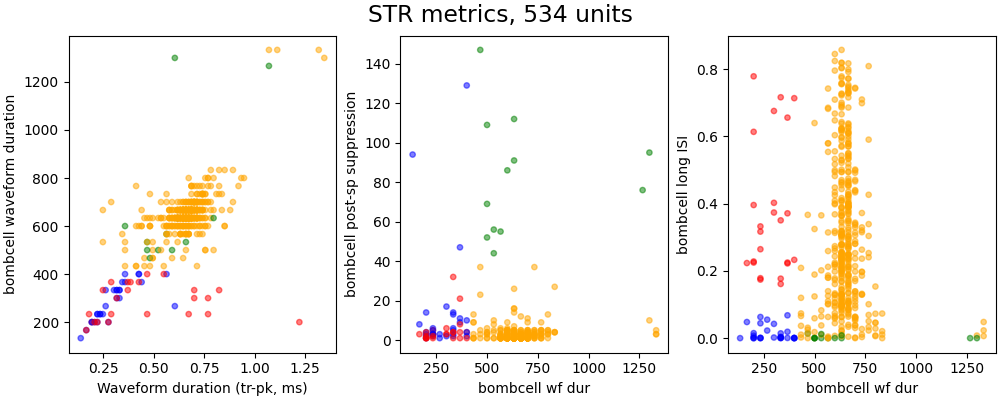

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(10,4), constrained_layout=True)

putcols = {'MSN': 'orange', 'FSI': 'b', 'UIN': 'r', 'TAN': 'g'}
colors = np.array([putcols[x] for x in regi_unitdf['cell_type_bc'].values])
axs[0].scatter(regi_unitdf['spike_duration'].values, regi_unitdf['bc_wfdur'].values, c=colors, s=15, alpha=0.5)
axs[0].set_xlabel('Waveform duration (tr-pk, ms)')
axs[0].set_ylabel('bombcell waveform duration')

axs[1].scatter(regi_unitdf['bc_wfdur'].values, regi_unitdf['bc_ps_supp_ms'].values, c=colors, s=15, alpha=0.5)
axs[1].set_xlabel('bombcell wf dur')
axs[1].set_ylabel('bombcell post-sp suppression')
# axs[1].set_ylim([-2, 2])

axs[2].scatter(regi_unitdf['bc_wfdur'].values, regi_unitdf['bc_proplongisi'].values, c=colors, s=15, alpha=0.5)
axs[2].set_xlabel('bombcell wf dur')
axs[2].set_ylabel('bombcell long ISI')
# axs[2].set_ylim([-2, 2])

fig.suptitle('{} metrics, {:d} units'.format(pregion, len(regi_unitdf)))

### Cortex

In [30]:
pregion = 'MO'
FR_min = 0.05
regi_unitdf = unit_info[(unit_info['parent_region'] == pregion) & (unit_info['firing_rate'] > FR_min)]
print(len(regi_unitdf))
# print(np.unique(regi_unitdf['region'].values))
print(np.unique(regi_unitdf['probe'].values))
regi_unitdf.head(10)

282
['probeF']


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,CV_ISI,prop2,num_LTS_bursts,CV2,CV_ISI_in,num_bursts_in,CV_ISI_out,num_bursts_out,bc_wfdur,bc_ps_supp_ms,bc_proplongisi,cell_type_bc,cell_type_LC
1095,F459,probeF,216,1500,0.274707,ccg,182,113,161,3.247475,0.99,0.089863,0.323694,14128,MO,1.224153,0.006937,182,1.019046,1.000869,46,1.246812,94,266.666667,3.0,0.006937,FS,FS
1096,F460,probeF,218,1480,0.233501,ccg,182,112,161,1.306299,0.99,0.353545,0.500000,5683,MO,2.011436,0.105069,24,1.030706,1.179361,2,1.771800,8,233.333333,6.0,0.105069,FS,FS
1097,F461,probeF,218,1480,0.645561,ccg,182,112,161,2.280910,0.99,0.182161,0.254754,9923,MO,1.313788,0.024894,202,1.108840,1.121798,53,1.394663,44,666.666667,3.0,0.024894,RS,RS
1098,F464,probeF,222,1440,0.480737,scwm,181,111,160,1.414334,0.99,0.215350,0.487516,6153,MO,1.634191,0.085338,91,1.087463,1.342179,10,1.551923,19,766.666667,3.0,0.085338,RS,RS
1099,F465,probeF,223,1440,0.260972,scwm,181,111,160,1.994733,0.99,0.000000,0.005568,8678,MO,1.211789,0.033652,317,1.016345,1.047113,77,1.244662,173,266.666667,2.0,0.033652,FS,FS
1100,F466,probeF,223,1440,0.521943,scwm,181,111,160,1.120802,0.99,0.000000,0.005097,4876,MO,1.970845,0.145846,177,1.199702,2.018481,28,2.165430,94,633.333333,2.0,0.145846,RS,RS
1101,F469,probeF,228,1380,0.178559,MOp6b,181,108,159,8.639322,0.99,0.049635,0.000164,37585,MO,2.610350,0.005215,1540,0.908071,1.636316,558,1.993288,497,200.000000,2.0,0.005215,FS,FS
1102,F470,probeF,228,1380,0.233501,MOp6b,181,108,159,2.044383,0.99,0.041227,0.063154,8894,MO,1.904104,0.065895,75,1.065019,1.467251,14,2.066594,43,233.333333,3.0,0.065895,FS,FS
1103,F471,probeF,229,1380,0.480737,MOp6b,181,108,159,4.637214,0.99,0.016026,0.124930,20174,MO,2.697746,0.018242,932,0.944807,1.628605,225,2.032203,239,500.000000,2.0,0.018242,RS,RS
1104,F474,probeF,230,1360,0.727973,MOp6a,181,108,158,1.845323,0.99,0.000000,0.131303,8028,MO,1.534800,0.049832,281,1.144133,1.181229,60,1.468627,96,733.333333,2.0,0.049832,RS,RS


Text(0.5, 1.0, 'MO putative cell types (bombcell)')

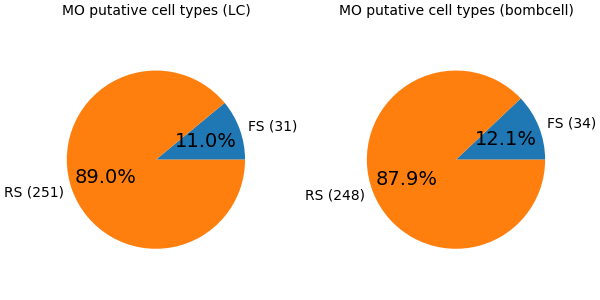

In [31]:
labels = []
count = []
for typei in np.unique(regi_unitdf['cell_type_LC'].values):
    tdf = regi_unitdf[regi_unitdf['cell_type_LC'] == typei]
    labels.append('{} ({:d})'.format(typei, len(tdf)))
    count.append(len(tdf))

labelsbc = []
countbc = []
for typei in np.unique(regi_unitdf['cell_type_bc'].values):
    tdf = regi_unitdf[regi_unitdf['cell_type_bc'] == typei]
    labelsbc.append('{} ({:d})'.format(typei, len(tdf)))
    countbc.append(len(tdf))


fig, axs = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
axs[0].pie(count, labels=labels, autopct='%1.1f%%')
axs[0].axis('equal')
axs[0].set_title('{} putative cell types (LC)'.format(pregion))

axs[1].pie(countbc, labels=labelsbc, autopct='%1.1f%%')
axs[1].axis('equal')
axs[1].set_title('{} putative cell types (bombcell)'.format(pregion))

Choose an example unit

In [92]:
pregion = 'MO'
FR_min = 0.05
regi_unitdf = unit_info[(unit_info['parent_region'] == pregion) & (unit_info['firing_rate'] > FR_min)]
print(len(regi_unitdf))
print(np.unique(regi_unitdf['region'].values))
print(np.unique(regi_unitdf['probe'].values))
regi_unitdf.head(10)

282
['MOp2/3' 'MOp5' 'MOp6a' 'MOp6b' 'ccg' 'scwm']
['probeF']


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,CV_ISI,prop2,num_LTS_bursts,CV2,CV_ISI_in,num_bursts_in,CV_ISI_out,num_bursts_out,cell_type
1095,F459,probeF,216,1500,0.274707,ccg,182,113,161,3.247475,0.99,0.089863,0.323694,14128,MO,1.224153,0.006937,182,1.019046,1.000869,46,1.246812,94,FS
1096,F460,probeF,218,1480,0.233501,ccg,182,112,161,1.306299,0.99,0.353545,0.500000,5683,MO,2.011436,0.105069,24,1.030706,1.179361,2,1.771800,8,FS
1097,F461,probeF,218,1480,0.645561,ccg,182,112,161,2.280910,0.99,0.182161,0.254754,9923,MO,1.313788,0.024894,202,1.108840,1.121798,53,1.394663,44,RS
1098,F464,probeF,222,1440,0.480737,scwm,181,111,160,1.414334,0.99,0.215350,0.487516,6153,MO,1.634191,0.085338,91,1.087463,1.342179,10,1.551923,19,RS
1099,F465,probeF,223,1440,0.260972,scwm,181,111,160,1.994733,0.99,0.000000,0.005568,8678,MO,1.211789,0.033652,317,1.016345,1.047113,77,1.244662,173,FS
1100,F466,probeF,223,1440,0.521943,scwm,181,111,160,1.120802,0.99,0.000000,0.005097,4876,MO,1.970845,0.145846,177,1.199702,2.018481,28,2.165430,94,RS
1101,F469,probeF,228,1380,0.178559,MOp6b,181,108,159,8.639322,0.99,0.049635,0.000164,37585,MO,2.610350,0.005215,1540,0.908071,1.636316,558,1.993288,497,FS
1102,F470,probeF,228,1380,0.233501,MOp6b,181,108,159,2.044383,0.99,0.041227,0.063154,8894,MO,1.904104,0.065895,75,1.065019,1.467251,14,2.066594,43,FS
1103,F471,probeF,229,1380,0.480737,MOp6b,181,108,159,4.637214,0.99,0.016026,0.124930,20174,MO,2.697746,0.018242,932,0.944807,1.628605,225,2.032203,239,RS
1104,F474,probeF,230,1360,0.727973,MOp6a,181,108,158,1.845323,0.99,0.000000,0.131303,8028,MO,1.534800,0.049832,281,1.144133,1.181229,60,1.468627,96,RS


In [26]:
regi_unitdf[50:60]

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,CV_ISI,prop2,num_LTS_bursts,CV2,CV_ISI_in,num_bursts_in,CV_ISI_out,num_bursts_out,cell_type
777,F83,probeF,68,2980,0.329648,CP,194,172,187,4.026473,0.99,0.000000,0.000293,17517,STR,2.033008,0.014273,13,0.942101,1.402969,1,1.581602,3,FS
778,F84,probeF,69,2980,0.755444,CP,193,172,186,2.354235,0.99,0.994854,0.500000,10242,STR,1.250234,0.017967,142,1.014409,1.045529,43,1.051540,39,MSN
779,F85,probeF,69,2980,0.618090,CP,193,172,186,1.426747,0.99,1.989223,0.425373,6207,STR,1.489233,0.093136,137,1.175669,1.338384,42,1.450936,54,MSN
780,F87,probeF,68,2980,0.700503,CP,194,172,187,0.298130,0.99,4.846622,0.108132,1297,STR,1.652604,0.408951,30,1.255299,1.438374,12,1.957203,4,MSN
781,F88,probeF,72,2940,0.274707,CP,193,170,186,4.560440,0.99,0.045582,0.017969,19840,STR,2.055930,0.014920,1747,1.064186,1.662560,642,1.901089,424,FS
782,F89,probeF,73,2940,0.686767,CP,193,170,186,0.327552,0.93,3.212028,0.002287,1425,STR,2.643505,0.294944,45,1.328421,2.181093,8,2.212533,11,MSN
783,F90,probeF,73,2940,0.631826,CP,193,170,186,0.214690,0.89,3.738396,0.033677,934,STR,2.362718,0.411576,31,1.358773,1.520162,14,1.955665,11,MSN
784,F91,probeF,73,2940,0.425796,CP,193,170,186,6.938351,0.99,0.089482,0.032307,30185,STR,1.449115,0.000663,97,0.930735,1.376362,27,1.354538,27,FS
785,F92,probeF,73,2940,0.480737,CP,193,170,186,3.007270,0.99,1.857672,0.500000,13083,STR,1.299441,0.010472,401,1.165574,1.404940,110,1.258188,141,unc
786,F93,probeF,73,2940,0.563149,CP,193,170,186,0.178142,0.84,2.714849,0.058804,775,STR,2.547607,0.397933,11,1.309292,1.683405,3,1.814694,4,MSN


In [93]:
unitind = 1101
unitrow = unit_info.iloc[unitind]
print('Unit {}, {}: spike duration={:.2f}, spike count={:d}'.format(unitrow.unit_id, unitrow.region, unitrow.spike_duration, unitrow.spike_count))

Unit F469, MOp6b: spike duration=0.18, spike count=37585


In [94]:
uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
print(len(uspikes))

37585


In [95]:
acg_props = bc.compute_acg_properties(uspikes, ephys_param)
isi_props = bc.compute_isi_properties(uspikes, ephys_param)

In [96]:
pss_ms = acg_props.get('post_spike_suppression_ms', np.nan)
print(pss_ms)
propLongISI = isi_props.get('prop_long_isi', np.nan)
print(propLongISI)

2.0


In [98]:
probe_path = os.path.dirname(exp.ephys_params[unitrow.probe]['spike_clusters'])
print(probe_path)

E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_estim_2022-12-22_10-36-08\experiment1\probeF_sorted\continuous\Neuropix-PXI-100.0


In [85]:
templates = np.load(os.path.join(probe_path, 'templates.npy'))
print(templates.shape)

(1023, 82, 362)


In [99]:
utemplates = templates[int(unitrow.unit_id[1:]),:,:]
print(utemplates.shape)

(82, 362)


In [89]:
winv = np.load(os.path.join(probe_path, 'whitening_mat_inv.npy'))
print(winv.shape)

(362, 362)


In [100]:
utemplates_uw = templates[int(unitrow.unit_id[1:]),:,:].squeeze() @ winv
print(utemplates_uw.shape)

(82, 362)


In [101]:
wf_props = bc.compute_waveform_properties(utemplates_uw, ephys_param, float(exp.ephys_params[unitrow.probe]['ap_sample_rate']))
waveform_duration_pt = wf_props.get('waveform_duration_us', np.nan)
print(waveform_duration_pt)

200.0


In [67]:
len(unit_info)

1573

In [65]:
unit_info.iloc[-1]

unit_id                F1022
probe                 probeF
peak_ch                   56
depth                   3100
spike_duration      0.700503
region                    CP
CCF_AP                   195
CCF_DV                   177
CCF_ML                   189
firing_rate         0.243882
presence_ratio          0.78
isi_viol            2.896999
amplitude_cutoff    0.022572
spike_count             1061
parent_region            STR
CV_ISI              3.543253
prop2               0.284906
num_LTS_bursts            19
CV2                 1.318319
CV_ISI_in           1.728705
num_bursts_in              3
CV_ISI_out          2.174571
num_bursts_out             9
cell_type                MSN
Name: 1572, dtype: object

Testing bombcell classification

✅ ipywidgets available - interactive GUI ready


In [33]:
help(bc.compute_all_ephys_properties)

Help on function compute_all_ephys_properties in module bombcell.ephys_properties:

compute_all_ephys_properties(ephys_path, param, save_path)
    Compute all ephys properties for all units
    
    
    Parameters
    ----------
    ephys_path : str
        Path to ephys data
    param : dict
        Parameters dictionary with memory management settings
    save_path : str
        Path to save results
        
    Returns
    -------
    ephys_properties : list
        List of dictionaries containing all computed properties



In [35]:
choose_probe = 'probeF'
probe_path = os.path.dirname(exp.ephys_params[choose_probe]['cluster_metrics'])
print(probe_path)

dict_keys(['probe_info', 'num_chs', 'bit_volts', 'ap_continuous', 'ap_timestamps', 'ap_sample_rate', 'lfp_continuous', 'lfp_timestamps', 'lfp_sample_rate', 'spike_clusters', 'spike_times', 'cluster_group', 'cluster_metrics', 'waveforms'])

In [41]:
ephys_properties, ephys_param = bc.run_all_ephys_properties(ephys_path=probe_path)

Computing ephys properties for 1019 units ...


Computing ephys properties:   0%|          | 0/1019 [00:00<?, ?it/s]

C:\Users\lesliec\Miniconda3\envs\bombcell\Lib\site-packages\joblib\memory.py:603: UserWarning: Persisting input arguments took 2.08s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=True)[0]
C:\Users\lesliec\Miniconda3\envs\bombcell\Lib\site-packages\joblib\memory.py:603: UserWarning: Persisting input arguments took 0.64s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  return self._cached_call(args, kwargs, shelving=True)[0]
C:\Users\lesliec\Miniconda3\envs\bombcell\Lib\site-packages\joblib\memory.py:603: UserWarning: Persisting input arguments took 1.33s to run.If this happens often in your code, it can cause performance problems (resul

Ephys properties computation complete!
Ephys properties saved to: E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_estim_2022-12-22_10-36-08\experiment1\probeF_sorted\continuous\Neuropix-PXI-100.0\bombcell\templates._bc_ephysProperties.parquet
Parameters saved to: E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_estim_2022-12-22_10-36-08\experiment1\probeF_sorted\continuous\Neuropix-PXI-100.0\bombcell\_bc_ephysParameters.parquet


In [88]:
ephys_properties[87]

{'unit_id': 87,
 'postSpikeSuppression': 3.4456140350877194,
 'acg_tau_rise': 1.0,
 'acg_tau_decay': 35.1777243271794,
 'isi_cv': 1.6526045209441012,
 'isi_cv2': 1.255299118937596,
 'isi_skewness': 3.5700458777852275,
 'prop_long_isi': 0.4089506172839506,
 'waveform_duration_peak_trough': 633.3333333333334,
 'waveform_half_width': 0.6333333333333333,
 'peak_to_trough_ratio': 0.38599515,
 'n_peaks': 2,
 'n_troughs': 1,
 'firing_rate_mean': 0.2985140238873362,
 'firing_rate_std': 0.7112861459051194,
 'fano_factor': 1.6944881657770945,
 'postSpikeSuppression_ms': 1.0,
 'propLongISI': 0.4089506172839506,
 'waveformDuration_peakTrough_us': 633.3333333333334}

In [59]:
brain_region = 'striatum'
print(f"Classifying {brain_region} neurons...")
cell_types = bc.classify_and_plot_brain_region(ephys_properties, ephys_param, brain_region)

Classifying striatum neurons...


<IPython.core.display.Javascript object>

Plotted 993 units:
  Waveform duration range: 133-1367 μs
  Post-spike suppression range: 0.0-147.0 ms
  Prop long ISI range: 0.000-0.930

Striatum cell type distribution:
  MSN: 855 (83.9%)
  FSI: 79 (7.8%)
  TAN: 17 (1.7%)
  UIN: 42 (4.1%)
  Unknown: 26 (2.6%)


In [60]:
cell_types[87]

'MSN'

In [46]:
# Show classification results
if cell_types is not None:
    # Create combined results table
    ephys_df = pd.DataFrame(ephys_properties)
    ephys_properties_table = ephys_df.copy()
    ephys_properties_table['cell_type'] = cell_types
   
    print(ephys_properties_table)

      unit_id  postSpikeSuppression  acg_tau_rise  acg_tau_decay    isi_cv  \
0           0              0.707143           0.0     239.702015  0.988073   
1           1              3.909298           0.0      54.252494  4.138809   
2           2              1.096538           0.0      50.006517  1.091865   
3           3              0.802881           0.0     238.306698  1.103942   
4           4              0.019745           4.0     136.723759  2.727231   
...       ...                   ...           ...            ...       ...   
1014     1018              0.000000           2.0       4.144336  1.213429   
1015     1019              0.000000           0.0       2.704623  1.498207   
1016     1020              0.544950           4.0      29.982409  1.270712   
1017     1021              2.089362           4.0       4.425564  2.045125   
1018     1022              0.917757           3.0      15.741630  3.543254   

       isi_cv2  isi_skewness  prop_long_isi  waveform_duration_

In [48]:
cell_types

['Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Narrow-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Narrow-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Narrow-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Narrow-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Unknown',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spiking',
 'Wide-spik

In [69]:
uISI = np.diff(uspikes)
uCV = np.std(uISI) / np.mean(uISI)
print(uCV)

1.200868909425438


In [70]:
ubursts, uburstcounts = find_LTS_bursts(uspikes)
print(len(ubursts))

310


Calculate the proportion of ISIs greater than 2 s (from https://www.pnas.org/doi/10.1073/pnas.2410828121)

In [71]:
prop2 = np.sum(uISI > 2) / len(uISI)
print(prop2)

0.09247930910399424


Calculate mean CV2 (https://elephant.readthedocs.io/en/latest/reference/_toctree/statistics/elephant.statistics.cv2.html#elephant.statistics.cv2)

In [72]:
cv_i = np.diff(uISI) / (uISI[:-1] + uISI[1:])
CV2 = 2. * np.mean(np.abs(cv_i))
print(CV2)

1.0932504410368913


In [73]:
np.min(regi_unitdf['firing_rate'].values)

0.0071182225037111

In [35]:
pregion = 'TH'
FR_min = 0.05
regi_unitdf = unit_info[(unit_info['parent_region'] == pregion) & (unit_info['firing_rate'] > FR_min)]
print(len(regi_unitdf))
print(np.unique(regi_unitdf['region'].values))
print(np.unique(regi_unitdf['probe'].values))
regi_unitdf.head(10)

311
['LD' 'PO' 'VL' 'fi' 'root']
['probeB' 'probeC']


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,CV_ISI,prop2,num_LTS_bursts,CV2,CV_ISI_in,num_bursts_in,CV_ISI_out,num_bursts_out,cell_type
0,B0,probeB,0,3680,0.370854,PO,269,162,173,5.108656,0.99,0.788976,0.500000,22225,TH,2.425659,0.014264,590,1.034553,1.398043,138,2.087172,264,unc
1,B1,probeB,0,3680,0.398325,PO,269,162,173,11.458331,0.99,0.160769,0.001680,49849,TH,2.072512,0.000883,3054,0.898940,1.576292,843,1.884850,1063,unc
2,B2,probeB,0,3680,0.453266,PO,269,162,173,1.618910,0.99,1.446394,0.500000,7043,TH,2.638771,0.072991,339,1.163091,1.528207,76,1.859698,141,unc
3,B3,probeB,1,3680,0.384590,PO,269,162,173,4.637902,0.99,0.100133,0.000948,20177,TH,2.675274,0.018834,1559,0.980496,2.292351,471,2.225969,653,unc
4,B4,probeB,1,3680,0.494472,PO,269,162,173,6.090622,0.99,0.048773,0.085176,26497,TH,1.560503,0.002114,2884,1.045671,1.376947,971,1.531211,1103,unc
5,B5,probeB,1,3680,0.343384,PO,269,162,173,4.348966,0.99,0.195873,0.079074,18920,TH,2.304097,0.018341,1169,0.997812,1.728330,390,1.990033,474,unc
6,B6,probeB,5,3640,0.357119,PO,269,160,173,4.956259,0.99,0.056117,0.001053,21562,TH,2.609929,0.015352,1765,0.924425,2.095463,597,2.079122,685,unc
7,B7,probeB,1,3680,0.412060,PO,269,162,173,1.392956,0.99,1.287662,0.451247,6060,TH,2.983437,0.068823,243,1.129227,1.312132,11,1.822043,54,unc
8,B8,probeB,2,3660,0.384590,PO,269,161,173,7.798258,0.99,0.461851,0.001503,33926,TH,2.581827,0.005306,2625,0.959916,1.815505,833,2.150234,980,unc
9,B9,probeB,2,3660,0.467002,PO,269,161,173,2.650295,0.99,0.171719,0.481475,11530,TH,2.257924,0.044843,348,1.072486,1.556459,124,1.849811,161,unc


Text(0, 0.5, 'ISI CV (out only)')

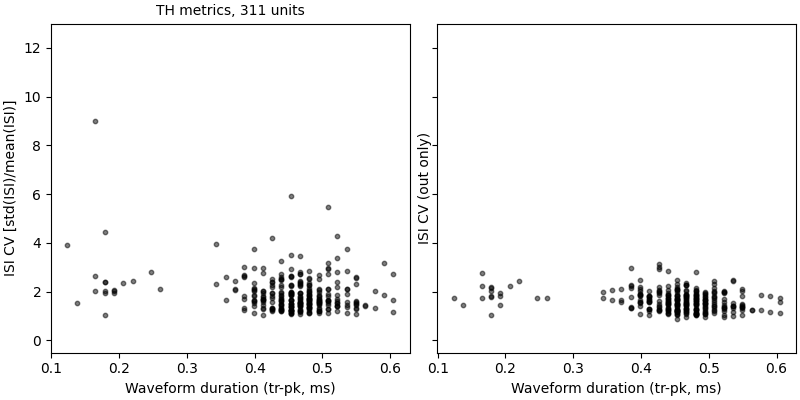

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True, sharey=True)

axs[0].scatter(regi_unitdf['spike_duration'].values, regi_unitdf['CV_ISI'].values, color='k', s=10, alpha=0.5)
axs[0].set_xlabel('Waveform duration (tr-pk, ms)')
axs[0].set_ylabel('ISI CV [std(ISI)/mean(ISI)]')
axs[0].set_title('{} metrics, {:d} units'.format(pregion, len(regi_unitdf)))
axs[0].set_ylim([-0.5, 13])

axs[1].scatter(regi_unitdf['spike_duration'].values, regi_unitdf['CV_ISI_out'].values, color='k', s=10, alpha=0.5)
axs[1].set_xlabel('Waveform duration (tr-pk, ms)')
axs[1].set_ylabel('ISI CV (out only)')
# axs[0].set_title('{} metrics, {:d} units'.format(pregion, len(regi_unitdf)))

Text(0, 0.5, 'CV2')

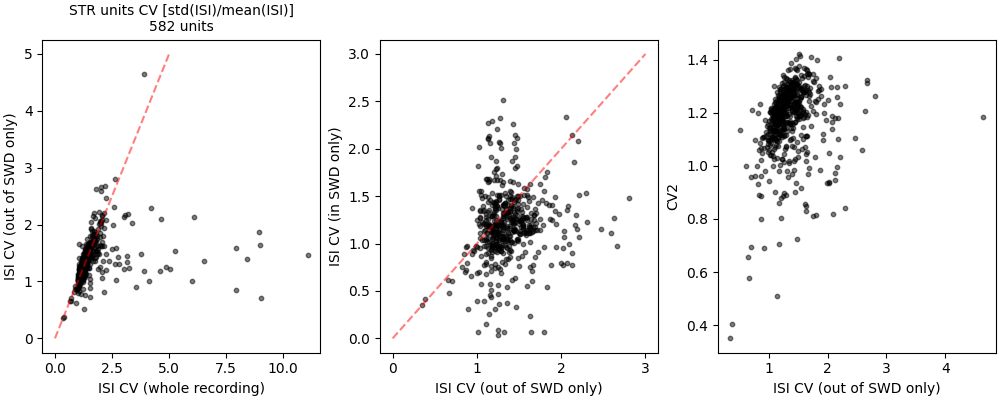

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(10,4), constrained_layout=True)
axs[0].plot([0,5], [0,5], c='r', linestyle='dashed', alpha=0.5)
axs[0].scatter(regi_unitdf['CV_ISI'].values, regi_unitdf['CV_ISI_out'].values, color='k', s=10, alpha=0.5)
axs[0].set_xlabel('ISI CV (whole recording)')
axs[0].set_ylabel('ISI CV (out of SWD only)')
axs[0].set_title('{} units CV [std(ISI)/mean(ISI)]\n{:d} units'.format(pregion, len(regi_unitdf)))
# ax.set_ylim([-0.5, 13])

axs[1].plot([0,3], [0,3], c='r', linestyle='dashed', alpha=0.5)
axs[1].scatter(regi_unitdf['CV_ISI_out'].values, regi_unitdf['CV_ISI_in'].values, color='k', s=10, alpha=0.5)
axs[1].set_xlabel('ISI CV (out of SWD only)')
axs[1].set_ylabel('ISI CV (in SWD only)')

# axs[2].plot([0,3], [0,3], c='r', linestyle='dashed', alpha=0.5)
axs[2].scatter(regi_unitdf['CV_ISI_out'].values, regi_unitdf['CV2'].values, color='k', s=10, alpha=0.5)
axs[2].set_xlabel('ISI CV (out of SWD only)')
axs[2].set_ylabel('CV2')

Text(0.5, 1.0, 'TH\nNumber of LTS bursts')

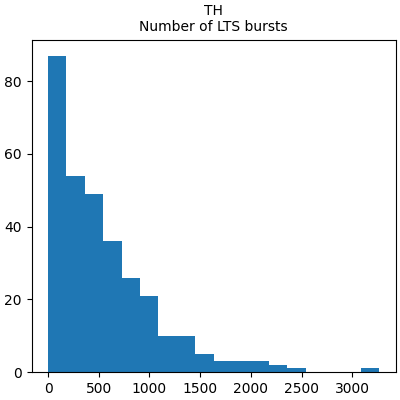

In [37]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ax.hist(regi_unitdf['num_bursts_out'].values)
ax.set_title('{}\nNumber of LTS bursts'.format(pregion))

Text(0.5, 1.0, 'TH\nProportion of time in ISI>2s')

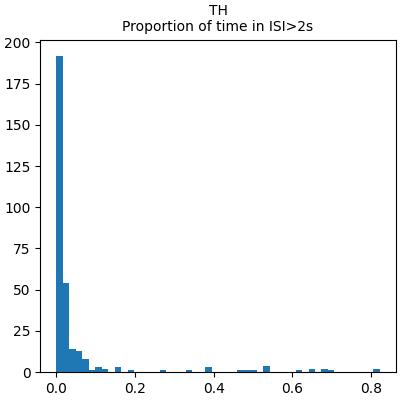

In [38]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ax.hist(regi_unitdf['prop2'].values, bins=50)
ax.set_title('{}\nProportion of time in ISI>2s'.format(pregion))

## Loop through all units to get spontaneous firing rates

In [21]:
deltat = 1. # window size, s
atime = eegts[0]
if exprow.genotype == 'GAT1-KO':
    print('GAT1: choose time before any stimuli')
    btime = stim_log.onset.values[0]
    print(' Spontaneous time: {:.2f} s'.format(btime-atime))
else:
    print('Control: some experiments are saline/psilocybin/isoflurane')
    if exprow.drug == 'isoflurane':
        print(' First stim: {:.2f} s; Iso on: {:.2f} s'.format(stim_log.onset.values[0], isots[iso_level > 4][0]))
        btime = np.min([stim_log.onset.values[0], isots[iso_level > 4][0]])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
    else:
        print(' First stim: {:.2f} s; First injection: {:.2f}'.format(stim_log.onset.values[0], exprow.inj_time))
        btime = np.min([stim_log.onset.values[0], exprow.inj_time])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
spontbins = np.arange(atime, btime, deltat)
spontSWD = autoSWD_df[(autoSWD_df['onset'] > atime) & (autoSWD_df['offset'] < btime)]

GAT1: choose time before any stimuli
 Spontaneous time: 1723.91 s


In [22]:
compstart = time.time()
spontFR = []
spontBR = []
spont_burstratio = []
units_SWD_FR = []
units_nonSWD_FR = []
units_SWD_BR = []
units_nonSWD_BR = []
units_SWD_burstratio = []
units_nonSWD_burstratio = []
for unitind, unitrow in unit_info.iterrows():
    uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
    ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
    ubcs = all_unit_all_spikes[unitrow.unit_id]['burst_counts']
    ## Spontaneous ##
    spikecounts, edges = np.histogram(uspikes, spontbins)
    spontFR.append(np.mean(spikecounts / deltat))
    burstcounts, edges = np.histogram(ubursts, spontbins)
    spontBR.append(np.mean(burstcounts / deltat))
    ## Burst ratio ##
    spont_burstratio.append(
        np.sum(ubcs[np.nonzero((ubursts >= atime) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= atime) & (uspikes <= btime))[0]))


    ## Get SWD info ##
    event_SWD_FR = []
    event_SWD_BR = []
    totSWDspikec = []
    totSWDburstc = []
    event_nonSWD_FR = []
    event_nonSWD_BR = []
    totnonSWDspikec = []
    totnonSWDburstc = []
    for j in range(len(spontSWD)-1):
        SWDeventj = spontSWD.iloc[j]
        SWDeventjj = spontSWD.iloc[j+1]
    
        ## within SWD ##
        SWDspikec = len(np.nonzero((uspikes >= SWDeventj.onset) & (uspikes <= SWDeventj.offset))[0])
        event_SWD_FR.append(SWDspikec / (SWDeventj.offset - SWDeventj.onset))
        totSWDspikec.append(SWDspikec)
    
        burstinds = np.nonzero((ubursts >= SWDeventj.onset) & (ubursts <= SWDeventj.offset))[0]
        event_SWD_BR.append(len(burstinds) / (SWDeventj.offset - SWDeventj.onset))
        totSWDburstc.append(np.sum(ubcs[burstinds]))
    
        ## out of SWD ##
        nonSWDspikec = len(np.nonzero((uspikes >= SWDeventj.offset) & (uspikes <= SWDeventjj.onset))[0])
        event_nonSWD_FR.append(nonSWDspikec / (SWDeventjj.onset - SWDeventj.offset))
        totnonSWDspikec.append(nonSWDspikec)
    
        nonburstinds = np.nonzero((ubursts >= SWDeventj.offset) & (ubursts <= SWDeventjj.onset))[0]
        event_nonSWD_BR.append(len(nonburstinds) / (SWDeventjj.onset - SWDeventj.offset))
        totnonSWDburstc.append(np.sum(ubcs[nonburstinds]))
    units_SWD_FR.append(np.mean(event_SWD_FR))
    units_nonSWD_FR.append(np.mean(event_nonSWD_FR))
    units_SWD_BR.append(np.mean(event_SWD_BR))
    units_nonSWD_BR.append(np.mean(event_nonSWD_BR))
    units_SWD_burstratio.append(np.sum(totSWDburstc) / np.sum(totSWDspikec))
    units_nonSWD_burstratio.append(np.sum(totnonSWDburstc) / np.sum(totnonSWDspikec))

unit_info['spont_FR'] = spontFR
unit_info['spont_BR'] = spontBR
unit_info['burst_ratio'] = spont_burstratio
unit_info['SWD_FR'] = units_SWD_FR
unit_info['nonSWD_FR'] = units_nonSWD_FR
unit_info['SWD_BR'] = units_SWD_BR
unit_info['nonSWD_BR'] = units_nonSWD_BR
unit_info['SWD_burst_ratio'] = units_SWD_burstratio
unit_info['nonSWD_burst_ratio'] = units_nonSWD_burstratio
compend = time.time()
print('Computation time: {:.2f} min'.format((compend-compstart)/60))

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


Computation time: 3.64 min


In [23]:
unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,SWD_FR,nonSWD_FR,SWD_BR,nonSWD_BR,SWD_burst_ratio,nonSWD_burst_ratio
0,B0,probeB,0,3640,0.576884,AMv,253,179,195,9.418763,0.99,0.016637,0.000034,62190,TH,9.100987,0.315148,0.063273,5.194705,8.827456,0.297656,0.292783,0.116959,0.060632
1,B1,probeB,0,3640,0.590620,AMv,253,179,195,8.409945,0.99,0.089089,0.307189,55529,TH,7.189205,0.066164,0.016055,3.045485,6.823664,0.095416,0.066364,0.048662,0.014783
2,B2,probeB,0,3640,0.535678,AMv,253,179,195,4.729525,0.99,0.139577,0.356767,31228,TH,4.597795,0.030760,0.011478,1.649302,4.373807,0.031793,0.027418,0.022727,0.011172
3,B3,probeB,0,3640,0.576884,AMv,253,179,195,2.060496,0.99,0.361000,0.500000,13605,TH,2.113175,0.033662,0.027991,1.149698,1.945563,0.035524,0.036650,0.054422,0.026911
4,B4,probeB,1,3640,0.508208,AMv,253,179,195,6.020648,0.99,0.075170,0.041239,39753,TH,4.760302,0.184562,0.080795,3.632534,4.482238,0.140764,0.142553,0.080913,0.080850


Plot all units from regions

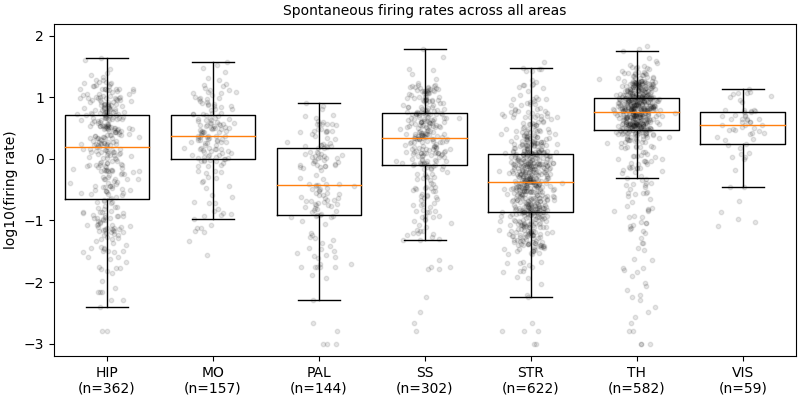

In [24]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
parent_regions = np.unique(unit_info['parent_region'].values)

rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = unit_info[unit_info['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    yvals = np.log10(regidf['spont_FR'].values + 1E-3)
    xs = np.random.normal(ii, 0.1, len(yvals))
    ax.boxplot(yvals, positions=[ii], widths=[0.8], showfliers=False,)
    ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
ax.set_xticks(np.arange(len(parent_regions)))
ax.set_xticklabels(rlabels)
ax.set_ylim([-3.2, 2.2])
ax.set_ylabel('log10(firing rate)')
ax.set_title('Spontaneous firing rates across all areas')

## Save ##
fig_name = '{}{}_spontFR_allregions.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

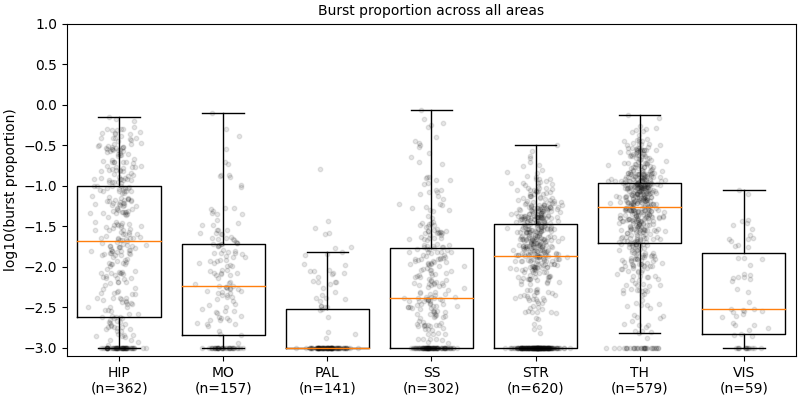

In [29]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
parent_regions = np.unique(unit_info['parent_region'].values)

rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = unit_info[unit_info['parent_region'] == pregi]
    yvals = np.log10(regidf['burst_ratio'].values[~np.isnan(regidf['burst_ratio'].values)] + 1E-3)
    rlabels.append('{}\n(n={:d})'.format(pregi, len(yvals)))
    # yvals = regidf['burst_ratio'].values
    xs = np.random.normal(ii, 0.1, len(yvals))
    ax.boxplot(yvals, positions=[ii], widths=[0.8], showfliers=False,)
    ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
ax.set_xticks(np.arange(len(parent_regions)))
ax.set_xticklabels(rlabels)
ax.set_ylim([-3.1, 1.0])
ax.set_ylabel('log10(burst proportion)')
ax.set_title('Burst proportion across all areas')

## Save ##
fig_name = '{}{}_spontBurstproportion_allregions.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

## Investigate some single units

In [25]:
regi_unitdf = unit_info[unit_info['parent_region'] == 'STR']
print(len(regi_unitdf))
print(np.unique(regi_unitdf['region'].values))
regi_unitdf.head()

586
['CP' 'ccb']


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,SWD_FR
1643,F32,probeF,42,3260,0.659296,CP,205,182,186,0.008169,0.41,0.000000,0.500000,58,STR,0.006893,0.000000,0.000000,0.008739
1644,F33,probeF,43,3260,0.343384,CP,205,182,186,10.099695,0.99,0.007245,0.000308,71709,STR,10.185578,0.001591,0.000677,5.560259
1645,F34,probeF,43,3260,0.618090,CP,205,182,186,0.759143,0.99,0.366406,0.033224,5390,STR,0.347826,0.000000,0.000000,0.266990
1646,F36,probeF,50,3180,0.782915,CP,204,179,184,0.004789,0.25,0.000000,0.500000,34,STR,0.002651,0.000000,0.000000,0.001390
1647,F37,probeF,53,3160,0.247236,CP,204,178,184,8.264091,0.99,0.006184,0.046901,58676,STR,10.238600,0.006893,0.002019,6.677388


In [26]:
regi_unitdf[80:90]

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,SWD_FR
1723,F128,probeF,96,2720,0.645561,CP,200,161,177,1.115052,0.99,10.826759,0.025554,7917,STR,1.172322,0.010604,0.028042,1.914032
1724,F129,probeF,96,2720,0.645561,CP,200,161,177,0.271827,0.99,24.290916,0.074886,1930,STR,0.278367,0.001060,0.011429,0.595310
1725,F130,probeF,96,2720,0.618090,CP,200,161,177,0.630412,0.99,10.626480,0.120878,4476,STR,0.583775,0.007423,0.040872,0.933454
1726,F131,probeF,97,2720,0.645561,CP,200,160,176,1.311246,0.99,6.601136,0.022852,9310,STR,1.969247,0.015376,0.025848,2.662587
1727,F132,probeF,97,2720,0.673032,CP,200,160,176,0.268165,0.99,9.543091,0.025758,1904,STR,0.263521,0.000530,0.006036,0.582097
1728,F133,probeF,97,2720,0.631826,CP,200,160,176,0.723932,0.99,8.159027,0.004859,5140,STR,0.922057,0.007423,0.025877,1.693579
1729,F134,probeF,97,2720,0.810385,CP,200,160,176,0.210982,0.99,27.276196,0.032920,1498,STR,0.264581,0.002121,0.024048,0.562441
1730,F136,probeF,98,2700,0.631826,CP,200,160,176,0.178589,0.96,26.482628,0.033632,1268,STR,0.167020,0.001060,0.022222,0.284228
1731,F137,probeF,98,2700,0.755444,CP,200,160,176,0.148730,0.99,11.932234,0.047205,1056,STR,0.110817,0.000530,0.014354,0.277487
1732,F138,probeF,98,2700,0.604355,CP,200,160,176,1.308289,0.99,8.975004,0.341608,9289,STR,0.986744,0.015907,0.051585,1.724124


In [27]:
unitind = 792
unitrow = unit_info.iloc[unitind]
print('Unit {}, {}: spike duration={:.2f}, spike count={:d}'.format(unitrow.unit_id, unitrow.region, unitrow.spike_duration, unitrow.spike_count))

Unit C511, dhc: spike duration=0.49, spike count=37971


In [28]:
uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
print(len(uspikes))
ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
print(len(ubursts))
ubcs = all_unit_all_spikes[unitrow.unit_id]['burst_counts']

37971
121


### Get the spontaneous time window to get mean firing rate

In [29]:
deltat = 1.0 # size of time bins (s)

In [30]:
atime = eegts[0]
if exprow.genotype == 'GAT1-KO':
    print('GAT1: choose time before any stimuli')
    btime = stim_log.onset.values[0]
    print(' Spontaneous time: {:.2f} s'.format(btime-atime))
else:
    print('Control: some experiments are saline/psilocybin/isoflurane')
    if exprow.drug == 'isoflurane':
        btime = np.min([stim_log.onset.values[0], isots[iso_level > 4][0]])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
    else:
        btime = np.min([stim_log.onset.values[0], exprow.inj_time])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
spontbins = np.arange(atime, btime, deltat)

GAT1: choose time before any stimuli
 Spontaneous time: 1886.30 s


In [31]:
## Firing rate ##
spikecounts, edges = np.histogram(uspikes, spontbins)
unitFR = np.mean(spikecounts / deltat)
print('Unit {} mean firing rate: {:.2f} Hz [log10={:.2f}]'.format(unitrow.unit_id, unitFR, np.log10(unitFR)))

## Burst rate ##
burstcounts, edges = np.histogram(ubursts, spontbins)
unitBR = np.mean(burstcounts / deltat)
print('Unit {} mean burst rate: {:.2f} Hz [log10={:.2f}]'.format(unitrow.unit_id, unitBR, np.log10(unitBR)))

## Compute the burst proportion: # spikes in bursts / # total spikes ##
burst_ratio = np.sum(ubcs[np.nonzero((ubursts >= atime) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= atime) & (uspikes <= btime))[0])
print('Unit {} burst proportion: {:.2f}'.format(unitrow.unit_id, burst_ratio))

Unit C511 mean firing rate: 4.95 Hz [log10=0.69]
Unit C511 mean burst rate: 0.01 Hz [log10=-2.10]
Unit C511 burst proportion: 0.00


### Get spontaneous firing for SWD and not

In [32]:
autoSWD_df.tail()

,onset,offset,duration,spike_count,SWD_spike_times
1047,7092.399350,7093.288549,0.889199,4,"[7092.399349751857, 7092.722949542853, 7093.09..."
1048,7125.280934,7125.966134,0.685200,4,"[7125.280934257315, 7125.436934206937, 7125.79..."
1049,7131.890532,7132.539332,0.648800,3,"[7131.890532122845, 7132.208932020022, 7132.53..."
1050,7144.637728,7145.770128,1.132400,5,"[7144.63772800633, 7144.952127904799, 7145.269..."
1051,7149.089327,7149.818126,0.728800,4,"[7149.089326568754, 7149.474526444359, 7149.64..."


In [33]:
spontSWD = autoSWD_df[(autoSWD_df['onset'] > atime) & (autoSWD_df['offset'] < btime)]
spontSWD.tail()

,onset,offset,duration,spike_count,SWD_spike_times
385,1906.785480,1907.295476,0.509997,3,"[1906.7854796428342, 1907.1174774985468, 1907...."
386,1911.672248,1913.563836,1.891588,11,"[1911.6722480804754, 1911.8194471297552, 1911...."
387,1915.677422,1916.507817,0.830395,6,"[1915.6774222121037, 1915.8370211812958, 1916...."
388,1917.570610,1918.447804,0.877194,6,"[1917.5706099844992, 1917.741408881354, 1917.9..."
389,1932.274915,1932.839711,0.564796,4,"[1932.2749150132404, 1932.457313835174, 1932.6..."


In [34]:
compstart = time.time()
all_SWD_FR = []
all_SWD_BR = []
totSWDspikec = []
totSWDburstc = []
all_nonSWD_FR = []
all_nonSWD_BR = []
totnonSWDspikec = []
totnonSWDburstc = []
for j in range(len(spontSWD)-1):
    SWDeventj = spontSWD.iloc[j]
    SWDeventjj = spontSWD.iloc[j+1]

    ## within SWD ##
    SWDspikec = len(np.nonzero((uspikes >= SWDeventj.onset) & (uspikes <= SWDeventj.offset))[0])
    all_SWD_FR.append(SWDspikec / (SWDeventj.offset - SWDeventj.onset))
    totSWDspikec.append(SWDspikec)

    burstinds = np.nonzero((ubursts >= SWDeventj.onset) & (ubursts <= SWDeventj.offset))[0]
    all_SWD_BR.append(len(burstinds) / (SWDeventj.offset - SWDeventj.onset))
    totSWDburstc.append(np.sum(ubcs[burstinds]))

    ## out of SWD ##
    nonSWDspikec = len(np.nonzero((uspikes >= SWDeventj.offset) & (uspikes <= SWDeventjj.onset))[0])
    all_nonSWD_FR.append(nonSWDspikec / (SWDeventjj.onset - SWDeventj.offset))
    totnonSWDspikec.append(nonSWDspikec)

    nonburstinds = np.nonzero((ubursts >= SWDeventj.offset) & (ubursts <= SWDeventjj.onset))[0]
    all_nonSWD_BR.append(len(nonburstinds) / (SWDeventjj.onset - SWDeventj.offset))
    totnonSWDburstc.append(np.sum(ubcs[nonburstinds]))
compend = time.time()
print(compend - compstart)

0.2887582778930664


In [46]:
print(np.mean(all_SWD_FR))
print(np.mean(all_nonSWD_FR))

4.3350227633322875
5.189754382288044


In [47]:
print(np.mean(all_SWD_BR))
print(np.mean(all_nonSWD_BR))

0.0017206665486152013
0.007092745842638542


In [57]:
print(np.sum(totSWDburstc) / np.sum(totSWDspikec))
print(np.sum(totnonSWDburstc) / np.sum(totnonSWDspikec))

0.0017201834862385322
0.005693855932203389


In [55]:
np.sum(totSWDburstc)

3

Individual trial

In [34]:
indi = 0
SWDeventi = spontSWD.iloc[indi]
SWDeventii = spontSWD.iloc[indi+1]

In [35]:
SWDeventi

onset                                                      55.904357
offset                                                     56.411553
duration                                                    0.507196
spike_count                                                        4
SWD_spike_times    [55.904356981838816, 56.06715561497322, 56.237...
Name: 0, dtype: object

In [36]:
SWDeventii

onset                                                      61.299912
offset                                                     63.137896
duration                                                    1.837985
spike_count                                                        9
SWD_spike_times    [61.299911680487725, 61.5323097292619, 61.8255...
Name: 1, dtype: object

In [41]:
SWDspikec = len(np.nonzero((uspikes >= SWDeventi.onset) & (uspikes <= SWDeventi.offset))[0])
SWD_FR = SWDspikec / (SWDeventi.offset - SWDeventi.onset)
print(SWD_FR)

nonSWDspikec = len(np.nonzero((uspikes >= SWDeventi.offset) & (uspikes <= SWDeventii.onset))[0])
nonSWD_FR = nonSWDspikec / (SWDeventii.onset - SWDeventi.offset)
print(nonSWD_FR)

0.0
5.523325974423183


In [42]:
SWDburstc = len(np.nonzero((ubursts >= SWDeventi.onset) & (ubursts <= SWDeventi.offset))[0])
SWD_BR = SWDburstc / (SWDeventi.offset - SWDeventi.onset)
print(SWD_BR)

nonSWDburstc = len(np.nonzero((ubursts >= SWDeventi.offset) & (ubursts <= SWDeventii.onset))[0])
nonSWD_BR = nonSWDburstc / (SWDeventii.onset - SWDeventi.offset)
print(nonSWD_BR)

0.0
0.0
